<a href="https://colab.research.google.com/github/pashanushkarev/Bilateral-filtering-on-CUDA/blob/main/Bilateral_filtering_on_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import sys
import math
import time
import pycuda.autoinit
import pycuda.driver as drv
from pycuda.compiler import SourceModule
import cv2
from matplotlib import pyplot as plt

In [ ]:
image = cv2.imread('filefortest.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

N, M = image.shape[0], image.shape[1]
sigma_r, sigma_d = 500, 500
block_size=(16,16,1)

# Bilateral filter CPU

In [ ]:
def bilateralFilterCPU(image, diameter, sigma_r, sigma_d):
  image_after_filtr = np.zeros(image.shape)
  radius = diameter//2
  for i in range(1, len(image)-1):
    for j in range(1, len(image[0])-1):
      h = 0
      k = 0
      for ik in range(i-radius, i+radius+1):
        for jk in range(j-radius, j+radius+1):
          x = ik - i
          y = jk - j
          w = math.exp(-((x**2-y**2)/(sigma_d**2))) * math.exp(((int(image[ik][jk])-int(image[i][j]))**2)/(sigma_r**2))
          h += image[ik][jk]*w
          k += w
      image_after_filtr[i][j] = h/k
  return image_after_filtr

In [ ]:
start_time_cpu = time.time()
filtered_image_cpu = bilateralFilterCPU(image, 3, sigma_r, sigma_d)
end_time_cpu = time.time() - start_time_cpu

print(f"Time CPU bilateral filter: {end_time_cpu} sec.")

Time CPU bilateral filter: 2.8663835525512695 sec.


# Bilateral filter GPU

ядро на С++

In [ ]:
kernel = SourceModule(
    """
    texture<unsigned int, 2, cudaReadModeElementType> tex_image;

  __global__ void bilateral_filter_GPU(unsigned char* image_after_filtr, int M, int N, float sigma_d, float sigma_r)
  {   
      int i = threadIdx.x + blockDim.x * blockIdx.x;
      int j = threadIdx.y + blockDim.y * blockIdx.y;
      if ((i < M) && (j < N)) {
              float h = 0;
              float k = 0;
              unsigned char f0 = tex2D(tex_image, i, j);
              for (int jk = i - 1; jk <= i + 1; jk++){
                  for (int ik = j - 1; ik <= j + 1; ik++){
                      unsigned char fi = tex2D(tex_image, ik, jk);
                      float g = exp(-(pow((ik - i), 2) - pow((jk - j), 2)) / pow(sigma_d, 2));
                      float r = exp(pow(fi - f0, 2) / pow(sigma_r, 2));
                      k += g * r;
                      h += g * r * tex2D(tex_image, ik, jk);
                  }
              }
              image_after_filtr[i * N + j] = h / k;
          }
  }
"""
)

In [ ]:
filtered_image_gpu = np.zeros((N, M), dtype = np.uint8)

bilateralFilterGPU = kernel.get_function("bilateral_filter_GPU")
tex_image = kernel.get_texref("tex_image")
drv.matrix_to_texref(replicate.astype(np.uint32), tex_image, order="C")


start_time_gpu = time.time()
bilateralFilterGPU(drv.Out(filtered_image_gpu), np.int32(N), np.int32(M), np.float32(sigma_r), np.float32(sigma_d), block=block_size, grid=grid_size, texrefs=[tex_image])
drv.Context.synchronize()
end_time_gpu = time.time() - start_time_gpu

print(f"Time bilateral filter GPU: {end_time_gpu} sec.")

Time bilateral filter GPU: 0.005658626556396484 sec.


# Bilateral filter Pillow

In [ ]:
from PIL import Image, ImageFilter

image = cv2.imread('filefortest.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
start_time_PIL = time.time()
new_image = cv2.bilateralFilter(image, 3, 500, 500)
end_time_PIL = time.time() - start_time_PIL

print(f"Time Pillow bilateralFilter: {end_time_gpu} sec.")

Time Pillow bilateralFilter: 0.005658626556396484 sec.


# Test

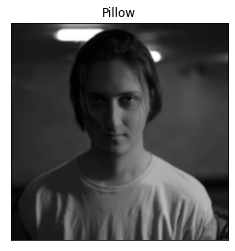

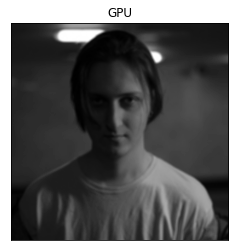

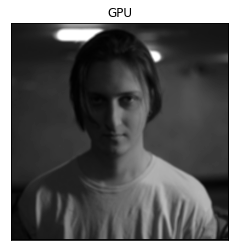

In [ ]:
plt.title('Pillow')
plt.imshow(new_image, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()


plt.title('GPU')
plt.imshow(filtered_image_gpu, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()

plt.title('GPU')
plt.imshow(filtered_image_cpu, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()

In [ ]:
SpeedGPU2CPU = end_time_cpu/end_time_gpu
print(f"Ускорение GPU перед CPU: {SpeedGPU2CPU}")

Ускорение GPU перед CPU: 506.5511081149406


In [ ]:
SpeedGPU2PIL = end_time_gpu/end_time_PIL
print(f"Ускорение Pillow перед GPU: {SpeedGPU2PIL}")

Ускорение Pillow перед GPU: 14.677798392084107
